In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import joblib
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance
import threading
import concurrent
from sklearn.metrics import r2_score
from VAE_OPTIMIZATION_WD import _dataset, VAE, study, compare_continuous, compare_integer#, compare_distributions_binned_aux, compare_distributions_binned

[I 2021-07-30 11:20:04,287] Using an existing study with name 'Optimizing the VAE with WD - BKG vs Random Sampling' instead of creating a new one.


## Loading the Study

In [2]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print(" TRIAL NUMBER:", trial.number)

Number of finished trials: 108
Best trial:
  Value: 10.894459985720914
  Params: 
    alpha: 221
    hidden_size: 40
    lr: 0.0005118528891017186
    n_layers_decoder: 6
    n_layers_encoder: 3
    n_units_decoder_l0: 5
    n_units_decoder_l1: 305
    n_units_decoder_l2: 135
    n_units_decoder_l3: 225
    n_units_decoder_l4: 395
    n_units_decoder_l5: 155
    n_units_encoder_l0: 380
    n_units_encoder_l1: 360
    n_units_encoder_l2: 240
 TRIAL NUMBER: 51


### Optuna Graphs

In [3]:
optuna.visualization.plot_param_importances(study) 

In [4]:
optuna.visualization.plot_optimization_history(study)

## Anomaly Detection

### Load the model

In [5]:
# Nao é o 49, 53, 33, 26, 25, 23, 22, 16
#name = "wd-sample_vs_data_trial_16"
#name = "wd-sample_vs_data_trial_{}".format(trial.number)
name = "CustomTrain_WD-Data_vs_Sampling_trial_51"
model = VAE.load_from_checkpoint(
    #join('models', f"sample_vs_data_trial_{study.best_trial.number}.ckpt"),
    join("models", name + ".ckpt"),
    #trial = study.trials[16], 
    trial = optuna.trial.FixedTrial(study.best_trial.params), 
    dataset = "bkg", 
    batch_size=512)

model.eval()

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [1, 10000] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 9996].

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [5, 500] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 495].



VAE(
  (encoder): Sequential(
    (0): Linear(in_features=69, out_features=380, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=380, out_features=360, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=360, out_features=240, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=240, out_features=40, bias=True)
  )
  (hidden2mu): Linear(in_features=40, out_features=40, bias=True)
  (hidden2log_var): Linear(in_features=40, out_features=40, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=5, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=5, out_features=305, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=305, out_features=135, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=135, out_features=225, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=225, ou

### Load data

In [6]:
# Bkg
bkg = _dataset(category='test',variant='bkg').all_data()
bkg_name = bkg['name']
bkg_weights = bkg['weights']
bkg.drop(columns=['weights', 'name'], inplace=True)
bkg.shape

(341121, 69)

## Check if z ~ N(0,1)

In [7]:
_, _, x_out, hidden = model.test_step(torch.from_numpy(bkg.to_numpy(dtype=np.float32)))
x_out = x_out.detach().numpy()
hidden = hidden.detach().numpy()
hidden.shape

(341121, 40)

<ipython-input-8-0c24cef1a002>:11: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



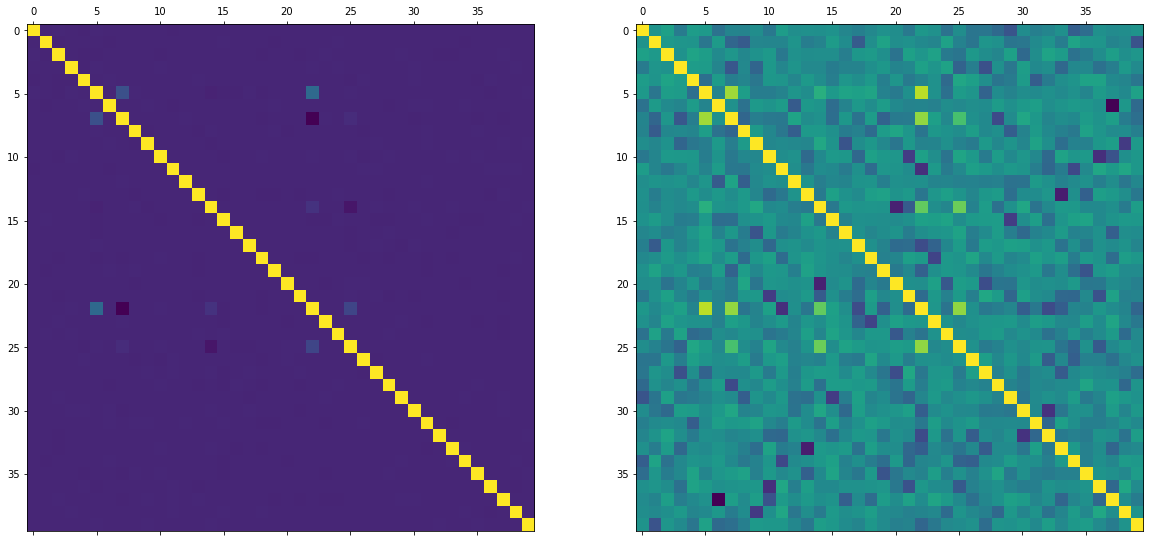

In [8]:
fig = plt.figure(figsize=[20,15])
i = 0

axes = fig.add_subplot(1,2,i+1)
i += 1
axes.matshow(pd.DataFrame(hidden).corr().apply(abs))

axes = fig.add_subplot(1,2,i+1)
i += 1
axes.matshow(pd.DataFrame(hidden).corr().apply(abs).apply(np.log))
fig.show()

In [17]:
corr = pd.DataFrame(hidden).corr().apply(abs)
corr.replace(1, 0, inplace=True)

print("Max:\t", round(corr.max().max(), 5))
print("Mean:\t", round(corr.mean().mean(), 5))

Max:	 0.26055
Mean:	 0.00226


In [25]:

fig = plt.figure(figsize=[25,70])
i = 0

for x in range(hidden.shape[1]):
    axes = fig.add_subplot(20,4,i+1)
    i += 1

    axes.hist(hidden[:, x], bins='auto')
    axes.axis(xmin=-5,xmax=5)
    #axes.title(f"Z{x}")
    print("Mean:", hidden[:, x].mean(), "\tStd:", hidden[:, x].std())


fig.show()

Mean: 0.000323358 	Std: 0.9993887
Mean: 0.003540015 	Std: 1.0000347
Mean: 0.0031874836 	Std: 0.9998471
Mean: -0.0011569082 	Std: 1.0002706
Mean: 0.0006054593 	Std: 1.0001651
Mean: -0.44266587 	Std: 0.8303659
Mean: 0.0027708465 	Std: 1.0005885
Mean: 0.1475216 	Std: 0.9638674
Mean: 0.0014227752 	Std: 1.0017699
Mean: 0.0013533126 	Std: 1.0011166
Mean: 0.0020498284 	Std: 0.99834967
Mean: 0.000816824 	Std: 0.9985647
Mean: 0.001085254 	Std: 1.0016922
Mean: 0.00013918456 	Std: 1.0028707


## Bkg Data vs Random Sampling Decoding

In [9]:
# Random sample from N(0,1)
sample = model.decode(torch.rand(bkg.shape[0], study.best_trial.params['hidden_size'])).detach().numpy()

# Make it a dataframe
sample = pd.DataFrame(sample, columns=bkg.columns)
sample.describe()

,Electron1_Eta,Electron1_PT,Electron1_Phi,Electron2_Eta,Electron2_PT,Electron2_Phi,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,...,MissingET_MET,MissingET_Phi,Muon1_Eta,Muon1_PT,Muon1_Phi,Muon2_Eta,Muon2_PT,Muon2_Phi,Muon_Multi,ScalarHT_HT
count,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,...,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000
mean,-0.674123,1.717143,-1.256939,-0.717115,0.571622,-0.928658,1.119047,-0.377353,-0.053422,1.017564,...,0.000946,0.293743,-0.120027,-0.871264,-0.115465,-0.109034,-0.726263,0.032204,-1.133115,1.011193
std,1.393187,0.998269,0.797885,1.499027,0.667010,1.143010,0.383393,0.904780,0.653629,0.545662,...,0.163070,0.288659,0.478912,0.374837,0.147382,0.376360,0.253956,0.254374,0.419603,0.608390
min,-3.734972,-0.954780,-3.323478,-3.974468,-1.017996,-3.809015,-0.967910,-2.270425,-1.193461,-0.413749,...,-0.495622,-0.534979,-2.499485,-1.736663,-0.998467,-2.892234,-2.116008,-1.769185,-1.508571,-0.791186
25%,-1.842113,0.935546,-1.908545,-1.909971,0.235197,-1.856052,1.145535,-1.167418,-0.586697,0.613377,...,-0.105795,0.074286,-0.085068,-1.061560,-0.198971,-0.098216,-0.854014,-0.075554,-1.327696,0.576676
50%,-0.602786,1.761700,-1.208419,-0.624715,0.513553,-0.762705,1.251469,-0.352994,-0.194989,1.005726,...,-0.025631,0.285677,0.000791,-0.927836,-0.101469,-0.005231,-0.770338,0.051464,-1.283209,1.003574
75%,0.481265,2.421193,-0.632282,0.455468,0.828730,-0.095913,1.295941,0.377008,0.410622,1.405747,...,0.076242,0.491562,0.053689,-0.807410,-0.017434,0.044955,-0.673607,0.188008,-1.162784,1.431609
max,2.598720,4.783638,1.081791,3.022489,4.139121,1.954298,1.472640,1.725875,2.088669,2.765406,...,0.745959,1.308378,0.768134,1.496929,0.581261,0.506050,1.147604,1.085809,1.076125,3.068351


In [10]:
def plot_graphs2(background, signal, bins=50, num_cols=4, first_name="Signal", second_name="Sampled"):
    WD_SCORE = 0
    R2_SCORE = 0
    # Ignoring irrelevant features such as 'name' and 'weights' in
    # the plotting of the data
    features  = list(background.columns)
    for x in ['name', 'weights']: 
        try:
            features.remove(x)
        except:
            pass

    # Plot creation
    num_rows = int(np.ceil((len(list(background.columns)) - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(signal[x].min(), background[x].min())
        hist_max = max(signal[x].max(), background[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(background[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()

        #WD_SCORE += wasserstein_distance(background[x], signal[x])
        #R2_SCORE += r2_score(background[x],signal[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()

Processing...:   0%|          | 0/69 [00:00<?, ?it/s]

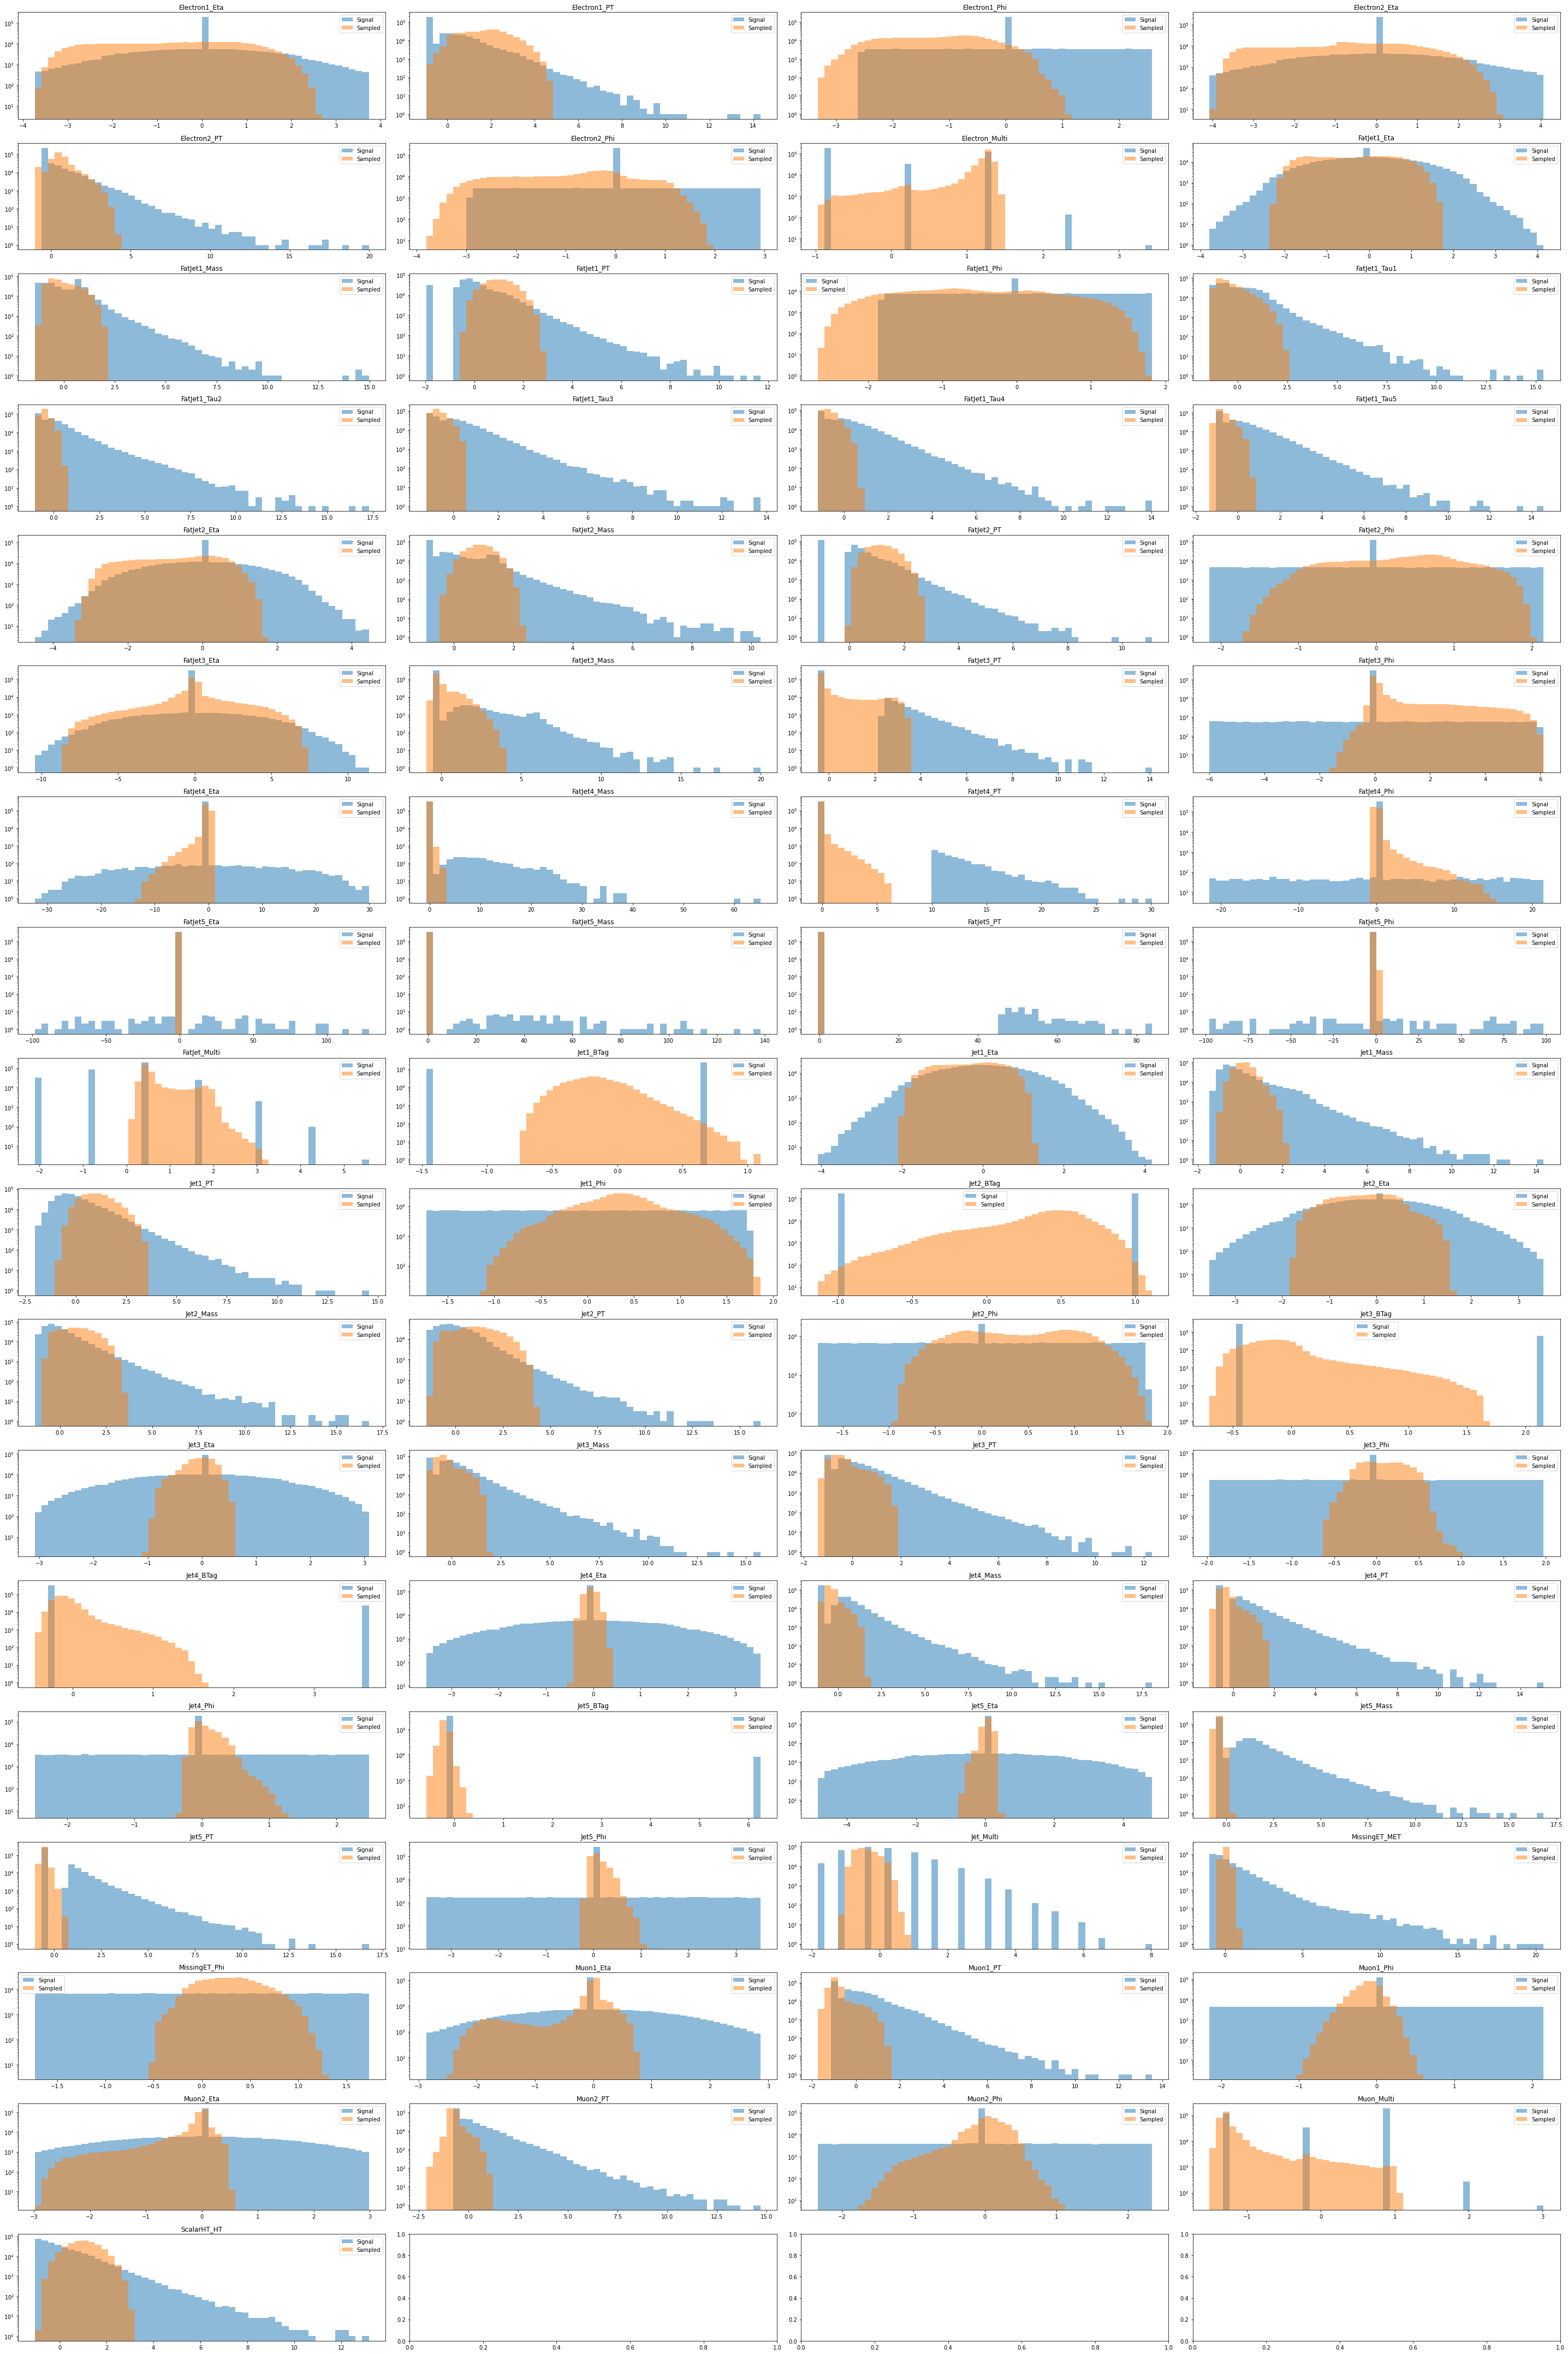

In [11]:
plot_graphs2(bkg, sample)

In [12]:
objective_score = 0
for idx in range(bkg.shape[1]):
    feature = bkg.columns[idx]
    if "Tag" in feature or "Multi" in feature:
        #print("Feature", feature, "é inteiro")
        objective_score += compare_integer(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
    else:
        #print("Feature", feature, "é continuo")
        objective_score += compare_continuous(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
print("WD Score:", objective_score)

WD Score: 13.789646213581776


## Bkg Data vs Reconstruction

In [13]:
def plot_graphs3(first, second, first_name="Signal", second_name="Sampled", bins=50, num_cols=4, num_features=69):

    R2_SCORE = 0

    # Reshape
    first = first.reshape(num_features, -1)
    second = second.reshape(num_features, -1)

    # Plot creation
    num_rows = int(np.ceil((num_features - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(range(num_features), total=num_features, desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(first[x].min(), second[x].min())
        hist_max = max(first[x].max(), second[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(first[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(second[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)

        x = x.cpu().numpy()
        output = output.cpu().numpy()

        #print("Input", np.isnan(x).any())
        #print("Output", np.isnan(output).any())


        #R2_SCORE += r2_score(first[x],second[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    #print("R2_SCORE:", R2_SCORE/num_features)

Processing...:   0%|          | 0/69 [00:00<?, ?it/s]

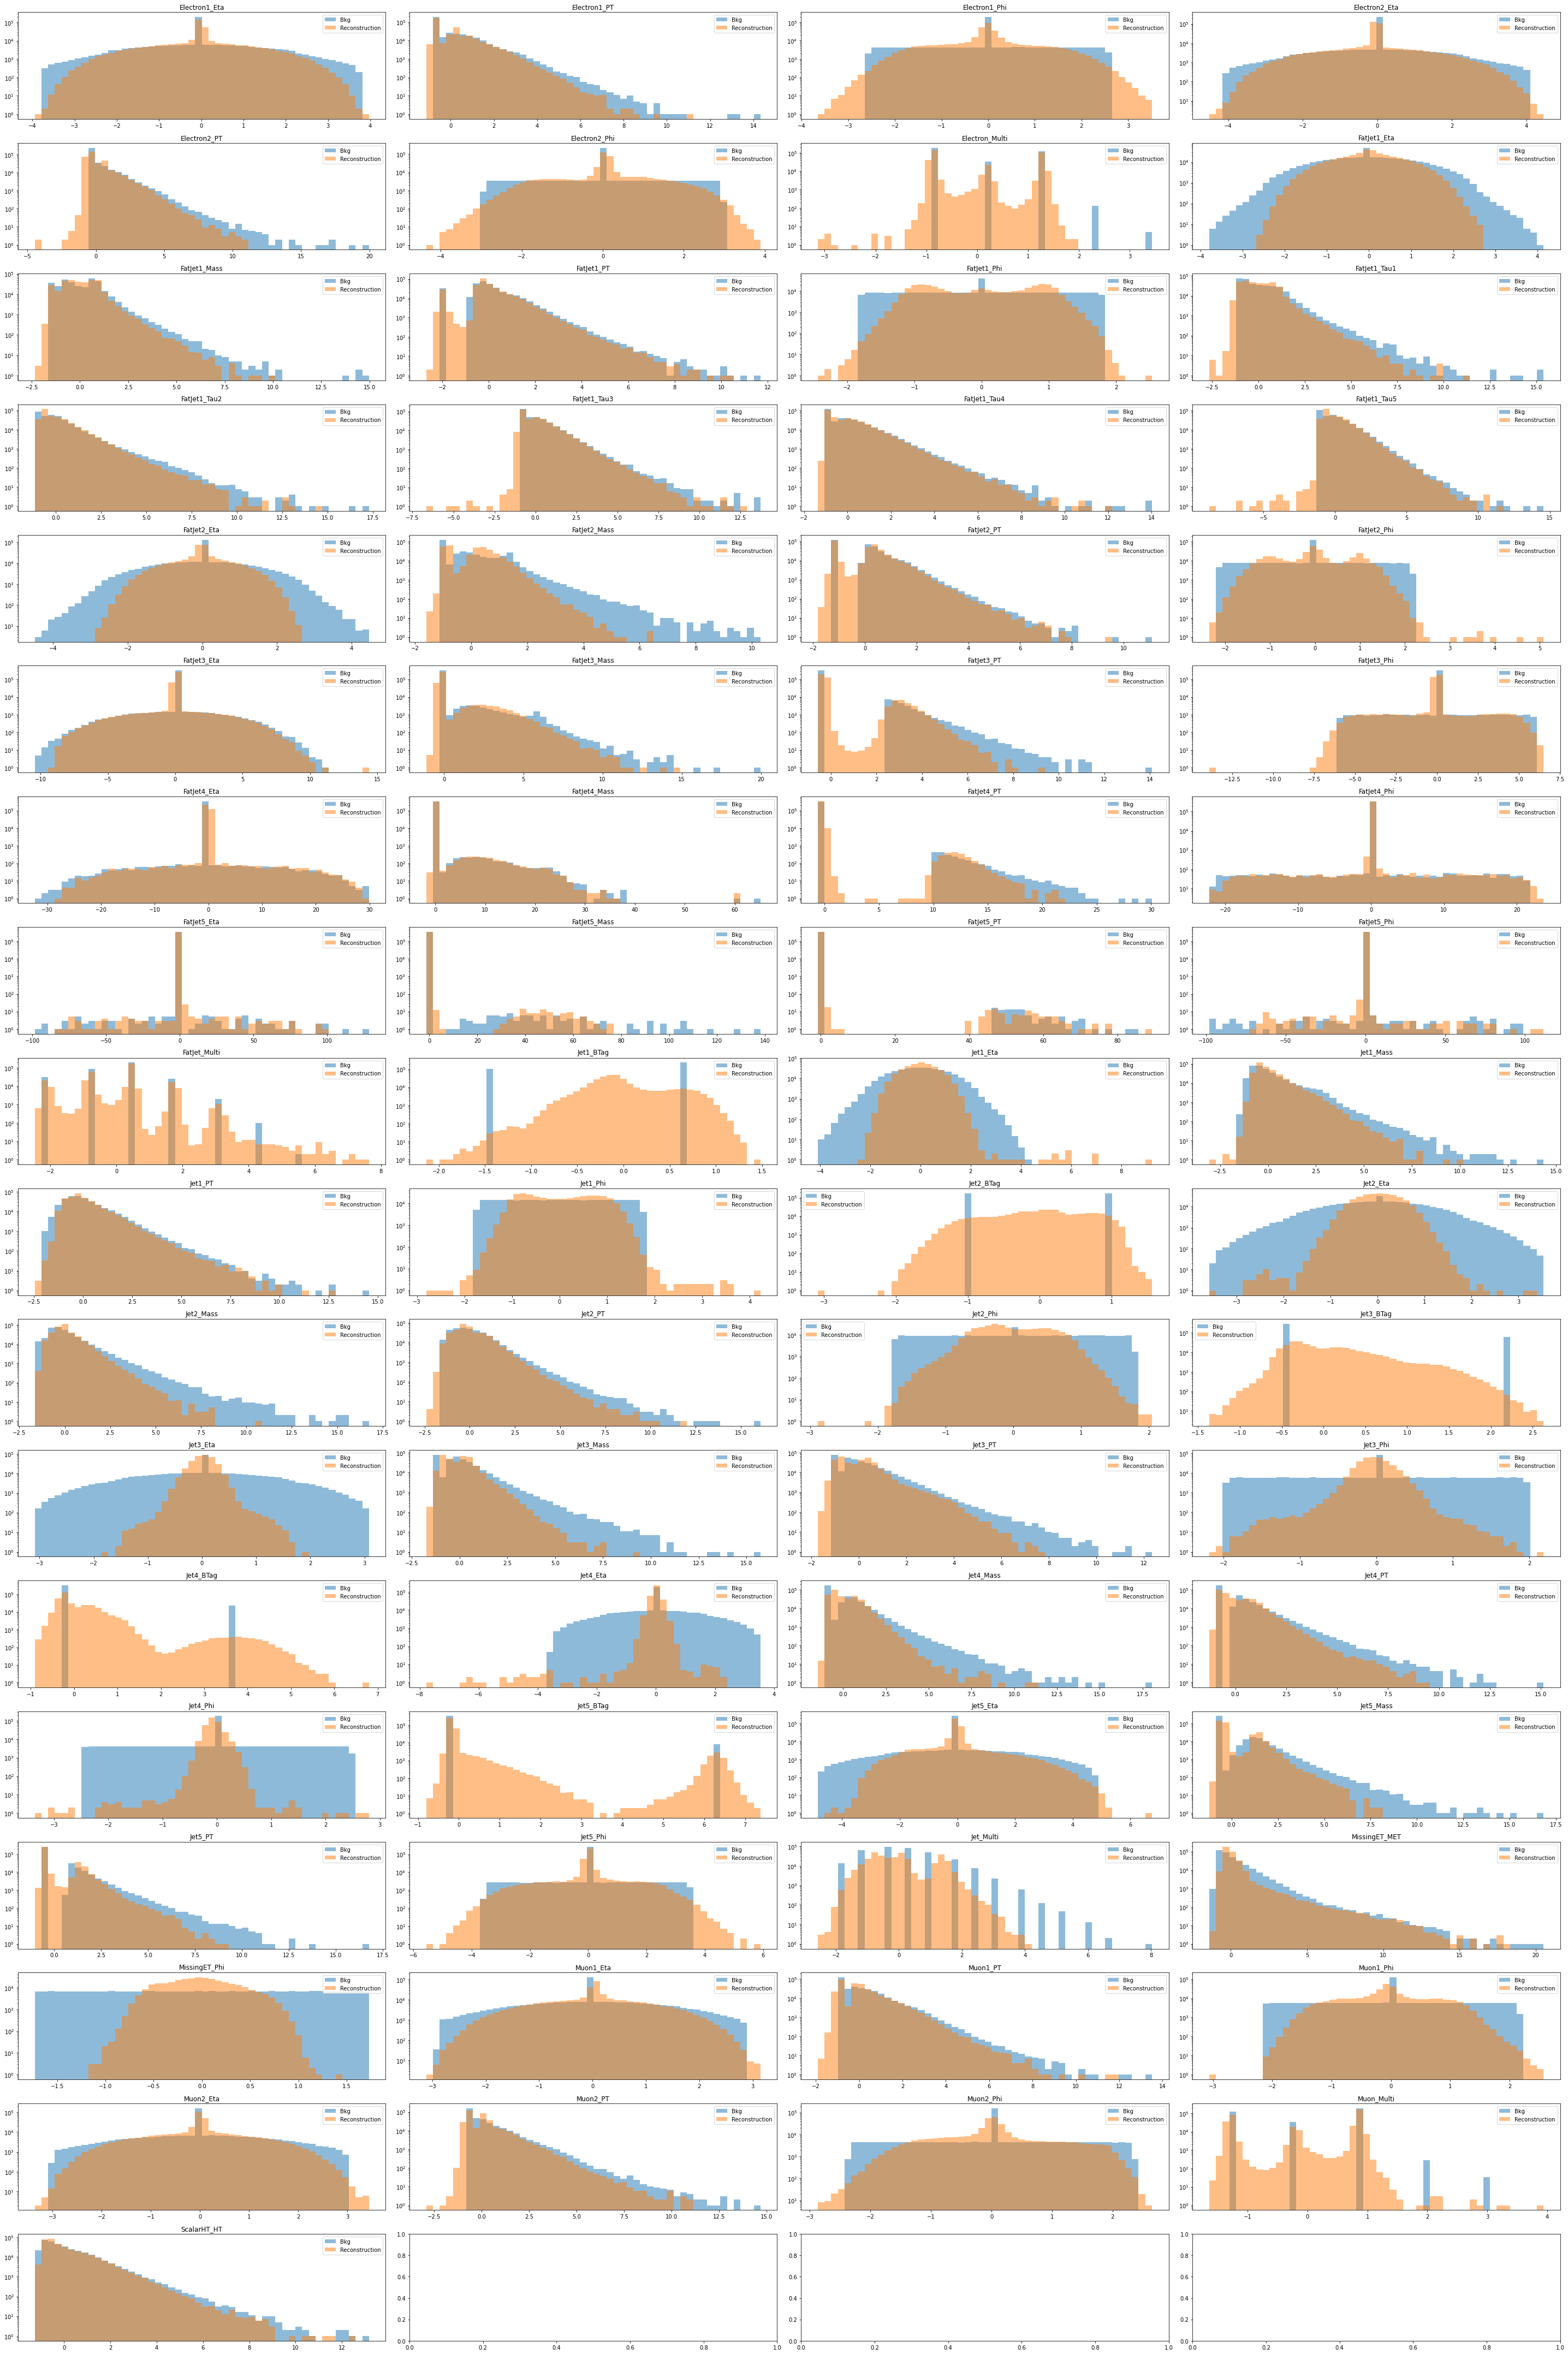

In [14]:
plot_graphs2(bkg, pd.DataFrame(x_out, columns=bkg.columns), first_name="Bkg", second_name="Reconstruction")

In [15]:
print("R2 Score:", r2_score(bkg.to_numpy(), x_out, sample_weight=bkg_weights.to_numpy()))

R2 Score: 0.6517173072568477


## Plot error distributions and ROC Scores

Load data

In [16]:
bkg = _dataset(category='test',variant='bkg').all_data()
signal = _dataset(category='all',variant='signal').all_data()
# signal.drop(columns=['weights'], inplace=True)

data = pd.concat([signal, bkg])
del signal, bkg

array(['hg3000_hq1000.h5', 'wohg_hq1000.h5', 'hg3000_hq1200.h5',
       'wohg_hq1200.h5', 'fcnc.h5', 'hg3000_hq1400.h5', 'wohg_hq1400.h5'],
      dtype=object)

Plot

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
def plot_graphs3(data, bins=50, num_cols=4):

    # Plot creation
    features = list(data['name'].unique())

    #num_rows = int(np.ceil((len(list(features)) - 1) / num_cols)) +1
    #fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    #i= 0


    distributions = {}

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        #row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        #i += 1

        # Input to the model
        sData = data.loc[data['name'] == x].drop(columns=['name', 'weights'])
        #sData = sData[:min_value]
        sData = torch.from_numpy(
            sData.to_numpy(dtype=np.float32)
        )

        # Pass input through model
        _, _, output, _ = model.test_step(sData)

        # Calculate the error dist
        error_dist = (sData - output)**2
        del output, sData
        error_dist = error_dist.detach().numpy().sum(axis=1)
        error_dist = np.log(error_dist)
        # Append to list
        distributions[x] = error_dist

    # Now we are going to find the maximum of all distributions
    max_of_dist = max(map(lambda x: max(x), distributions.values()))

    # Normalize the distributions
    # This way all values should be between 0 and one
    for x in distributions:
        distributions[x] = distributions[x] / max_of_dist
    # distributions =list(map(lambda x: x/max_of_dist, distributions))


    fig, ax = plt.subplots( figsize=(10,10))
    ax.set_yscale('log')

    

    for x in tqdm(distributions.keys(), desc="Processing..."):

        hist_range = (0, 1)        

        #x = x.replace(".h5", "")
        if x != 'bkg.h5':
            ax.hist(distributions[x], bins=bins, alpha=0.9, label=x.replace(".h5", ""), range=hist_range, histtype=u'step', linewidth=2, density=True)
        else:
            ax.hist(distributions[x], bins=bins, alpha=0.2, label=x.replace(".h5", ""), range=hist_range, density=True)

        # Plot rocs
        # ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)
        
    ax.autoscale(enable=True) 
    ax.set_title("Error Dist.")
    ax.legend()


    # PLOT ROC
    fig_roc, ax_roc = plt.subplots(figsize=(10,10))
    for x in tqdm(distributions.keys(), desc="Processing..."):
        if x != 'bkg.h5':
            # Set labels
            bkg_labels = np.zeros(distributions['bkg.h5'].shape[0]).astype(int)
            signal_labels = np.ones(distributions[x].shape[0]).astype(int)
            labels = np.concatenate([bkg_labels, signal_labels])

            weights = pd.concat([
                                data[data['name'] == "bkg.h5"]['weights'], 
                                data[data['name'] == x]['weights']
                                ])

            score = np.concatenate([distributions['bkg.h5'], distributions[x]]) 
            score = score / max_of_dist

            #print(labels.shape, weights.shape, score.shape, x)
            fpr, tpr, thr = roc_curve(
                    y_true=labels, 
                    y_score=score,
                    sample_weight=weights
                    )
            
            
            ax_roc.plot(fpr, tpr, label=x.replace('.h5', ''))
            ax_roc.plot([0,1],[0,1], 'k--')
   
            print(f"ROC SCORE for {x.replace('.h5', '')}:", 
                    roc_auc_score(y_true=labels, 
                    y_score=score,
                    sample_weight=weights))

    fig_roc.show()
    ax_roc.set_title(f"BKG vs Signals")
    ax_roc.legend()
                

    fig.tight_layout()
    plt.show()

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

ROC SCORE for hg3000_hq1000: 0.951377789207936
ROC SCORE for wohg_hq1000: 0.9533498100386918
ROC SCORE for hg3000_hq1200: 0.9498747997555597
ROC SCORE for wohg_hq1200: 0.9503755840620804
ROC SCORE for fcnc: 0.5788610747412212
ROC SCORE for hg3000_hq1400: 0.9507511841922061
ROC SCORE for wohg_hq1400: 0.9512920101835395


<ipython-input-17-ec75de003e3a>:104: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



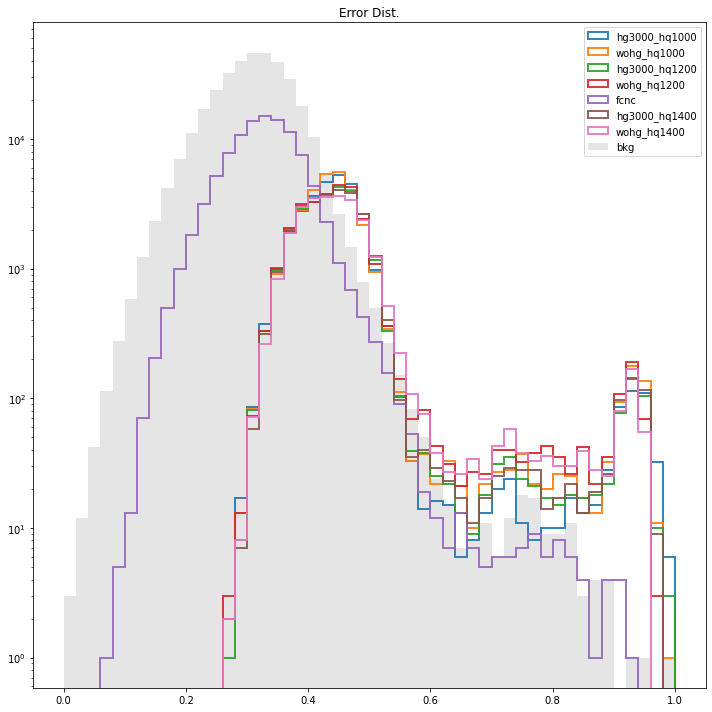

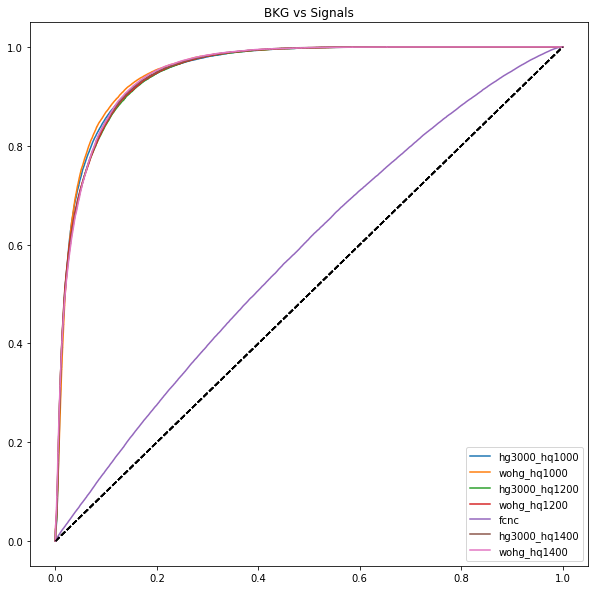

In [19]:
plot_graphs3(data)